In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import yaml
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import norm
import numpy as np

%matplotlib inline

In [41]:
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("The configuration file was not found!")

In [42]:
clients_path = config['data']['clean']['clean_1']
clients = pd.read_csv(clients_path)

sessions_path = config['data']['clean']['clean_2']
sessions = pd.read_csv(sessions_path)

outcome_path = config['data']['clean']['clean_3']
outcome = pd.read_csv(outcome_path)

time_path = config['data']['clean']['clean_4']
time = pd.read_csv(time_path)

repeated_steps_path = config['data']['clean']['clean_6']
repeated_steps = pd.read_csv(repeated_steps_path)

***Questions:***
1. Are the test and control groups similar enough to compare evenly?
2. What are the characteristics of those using the online process?
3. What is the process completion rate?
4. What is the error rate?
5. What is the process completion time?
6. Are there any relationships between client characteristics and completion / error rates?
7. What is the performance of each individual step in the process?
8. Hypothesis testing

### Are the test and control groups similar enough to compare evenly?

In [43]:
# Create the crosstab results
var_generation_crosstab = pd.crosstab(clients.variation, clients.generation, normalize='index')
var_gender_crosstab = pd.crosstab(clients.variation, clients.gender, normalize='index')
var_balance_crosstab = pd.crosstab(clients.variation, clients.balance_group, normalize='index')
var_tenure_crosstab = pd.crosstab(clients.variation, clients.tenure_group, normalize='index')
var_call_crosstab = pd.crosstab(clients.variation, clients.call_rate, normalize='index')
var_online_crosstab = pd.crosstab(clients.variation, clients.online_activity_level, normalize='index')

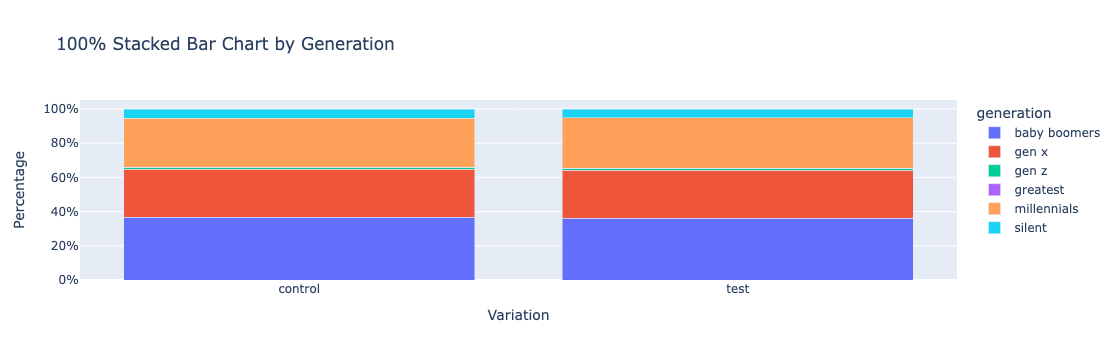

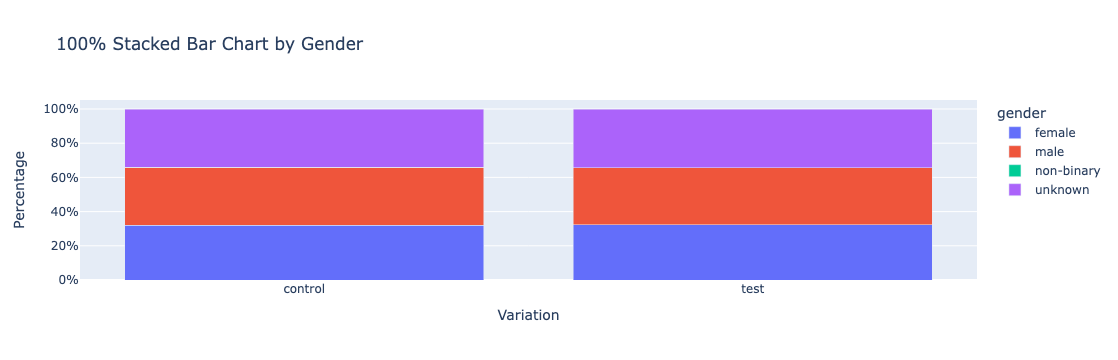

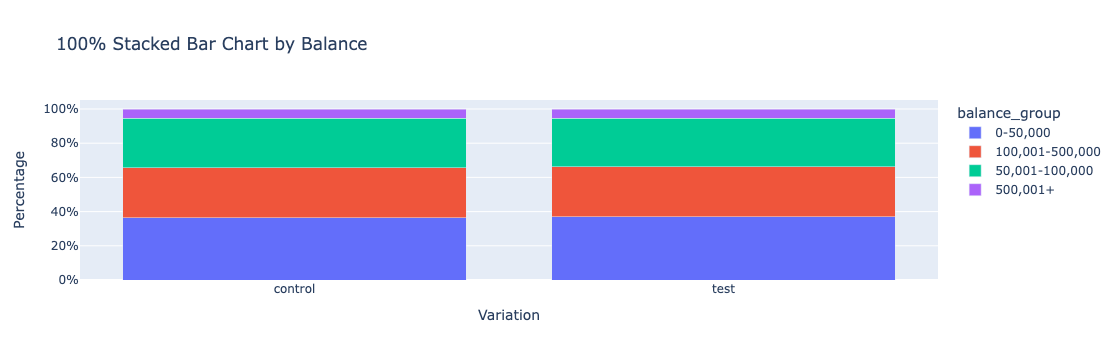

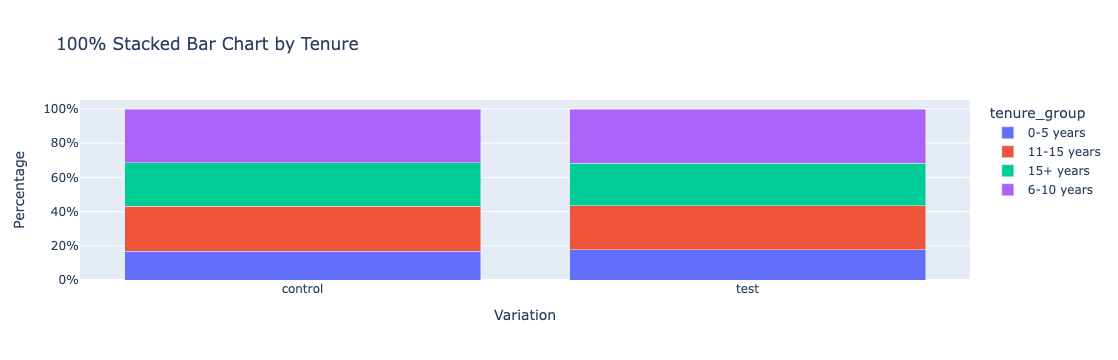

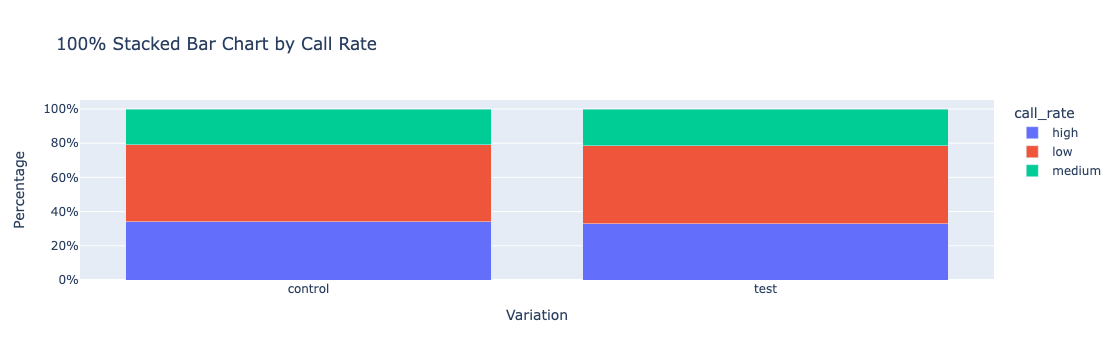

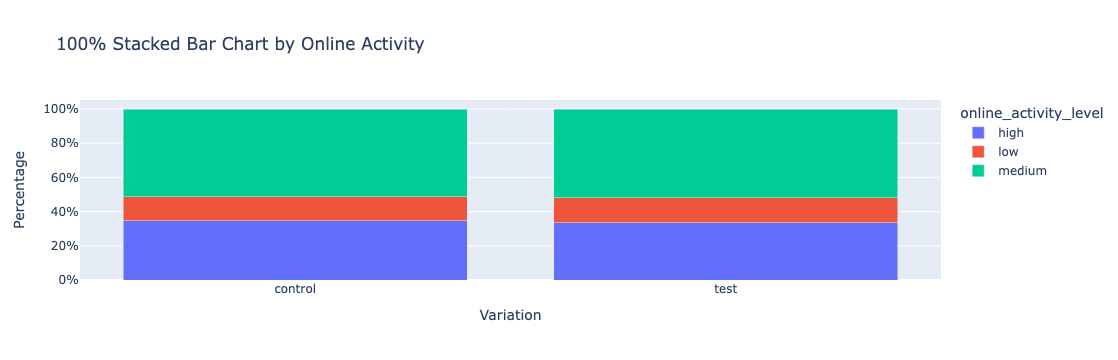

In [44]:
# Define a function to create the 100% stacked bar chart
def create_stacked_bar_chart(crosstab_df, id_var, value_var, title):
    # Convert the crosstab DataFrame to long format
    long_df = crosstab_df.reset_index().melt(id_vars='variation', var_name=id_var, value_name='percentage')

    # Create the 100% stacked bar chart using Plotly Express
    fig = px.bar(
        long_df,
        x='variation',
        y='percentage',
        color=id_var,
        title=title,
        labels={'percentage': 'Percentage', 'variation': 'Variation'},
    )

    # Update layout for better formatting
    fig.update_layout(
        yaxis_tickformat='.0%',
        xaxis=dict(title='Variation'),
        yaxis=dict(title='Percentage'),
        height=400,
        barmode='stack'
    )

    return fig

# Create the charts
generation = create_stacked_bar_chart(var_generation_crosstab, 'generation', 'percentage', '100% Stacked Bar Chart by Generation')
gender = create_stacked_bar_chart(var_gender_crosstab, 'gender', 'percentage', '100% Stacked Bar Chart by Gender')
balance = create_stacked_bar_chart(var_balance_crosstab, 'balance_group', 'percentage', '100% Stacked Bar Chart by Balance')
tenure = create_stacked_bar_chart(var_tenure_crosstab, 'tenure_group', 'percentage', '100% Stacked Bar Chart by Tenure')
call_rate = create_stacked_bar_chart(var_call_crosstab, 'call_rate', 'percentage', '100% Stacked Bar Chart by Call Rate')
online_activity = create_stacked_bar_chart(var_online_crosstab, 'online_activity_level', 'percentage', '100% Stacked Bar Chart by Online Activity')

generation.show()
gender.show()
balance.show()
tenure.show()
call_rate.show()
online_activity.show()


# SUMMARY
# The test and control group are comparable across all categories

### What are the characteristics of those using the online process?

In [45]:
online_users = clients[clients.online_activity_level == 'high']
online_users.head()

,client_id,client_tenure_yr,client_tenure_mnth,client_age,gender,num_accounts,balance,calls_6_mnth,logons_6_mnth,variation,yob,generation,tenure_group,online_activity_level,call_rate,balance_group
0,836976,6,73,60.5,unknown,2,45105.30,6,9,test,1956,baby boomers,6-10 years,high,high,"0-50,000"
1,2304905,7,94,58.0,unknown,2,110860.30,6,9,control,1959,baby boomers,6-10 years,high,high,"100,001-500,000"
2,1439522,5,64,32.0,unknown,2,52467.79,6,9,test,1985,millennials,0-5 years,high,high,"50,001-100,000"
9,8198645,15,189,54.5,female,2,382303.83,6,9,test,1962,baby boomers,11-15 years,high,high,"100,001-500,000"
11,2537139,8,99,51.5,unknown,2,135940.68,6,9,control,1965,gen x,6-10 years,high,high,"100,001-500,000"


### What is the process completion rate?

In [46]:
sessions.head()

,client_id,visitor_id,visit_id,process_step,date_time,variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,test


In [47]:
def count_unique(x):
    count = x.nunique()
    return count

funnel = sessions.pivot_table(index='process_step', columns='variation', values='visit_id', aggfunc=count_unique).sort_values(by='test', ascending=False)
funnel = funnel.reset_index()
funnel.columns.name = None

funnel

,process_step,control,test
0,start,30910,33157
1,step_1,23548,28285
2,step_2,20138,24503
3,step_3,18300,22186
4,confirm,16046,21731


In [48]:
def funnels(names, orientation, steps, values, textinfo):
    fig = go.Figure()

    for idx, name in enumerate(names):
        
        fig.add_trace(
            go.Funnel(
                name = names[idx],
                orientation = orientation,
                y = steps,
                x = values[idx],
                textinfo = textinfo
            )
        )
        
    return fig

names = ['Test', 'Control']
orientation = 'h'
steps = funnel.process_step.unique()
values = [funnel.test, funnel.control]

funnels_overall = funnels(
    names = names,
    orientation = orientation,
    steps = steps,
    values = values,
    textinfo = 'percent initial'
)

funnels_next = funnels(
    names = names,
    orientation = orientation,
    steps = steps,
    values = values,
    textinfo = 'percent previous'
)

funnels_overall.show()
funnels_next.show()

### What is the error rate?

In [49]:
outcome[outcome.error_in_session.notnull()]

,client_id,visit_id,variation,process_completed,error_in_session
0,9988021,781255054_21935453173_531117,test,no,yes
1,8320017,960651974_70596002104_312201,test,yes,no
2,4033851,949661017_22392791362_127391,control,yes,yes
3,1982004,132494692_73738638511_70823,test,yes,no
4,9294070,116640698_27328181095_188045,control,no,yes
...,...,...,...,...,...
69442,6426623,685634090_42070675506_389171,control,yes,no
69443,433098,773565250_67577573147_389841,control,yes,no
69444,7049106,412278907_8949064401_171038,test,no,yes
69445,1574008,528720790_71583064618_169151,test,yes,no


In [50]:
errors = outcome.pivot_table(index='error_in_session', columns='variation', values='visit_id', aggfunc='count').sort_values(by='test', ascending=False)
errors = errors.reset_index()
errors.columns.name = None

errors

,error_in_session,control,test
0,yes,23157,26636
1,no,9086,10568


In [51]:
def create_pie(df, values, names):

    pie = px.pie(errors, values=values, names=names)
    
    pie.update_layout(
        height = 400
    )
    
    return pie

names = errors.error_in_session
values = errors.test

errors_test = create_pie(errors, errors.test, names=names)
errors_control = create_pie(errors, errors.control, names=names)

errors_test.show()
errors_control.show()

### What is the total process completion time?

In [52]:
t = time.copy()
t.head()

,client_id,visitor_id,visit_id,s1_ttc,s2_ttc,s3_ttc,confirm_ttc,total_ttc
0,555,402506806_56087378777,637149525_38041617439_716659,7.0,32.0,99.0,20.0,158.0
1,647,66758770_53988066587,40369564_40101682850_311847,7.0,18.0,189.0,163.0,377.0
2,934,810392784_45004760546,7076463_57954418406_971348,NaN,NaN,NaN,NaN,NaN
3,1028,42237450_62128060588,557292053_87239438319_391157,49.0,72.0,275.0,NaN,NaN
4,1104,194240915_18158000533,543158812_46395476577_767725,NaN,NaN,NaN,NaN,NaN


In [53]:
t = t[(t[['s1_ttc', 's2_ttc', 's3_ttc', 'total_ttc']] > 0).all(axis=1)]

In [54]:
t = t.merge(clients, on='client_id', how='inner')

In [55]:
box = px.box(t, x='total_ttc', color='variation')
box.show()

In [56]:
def remove_outliers(df, group, column):
    grouped = df.groupby(group)
    cleaned_data = pd.DataFrame()

    for group_name, dataframe in grouped:
        q1 = dataframe[column].quantile(0.25)
        q3 = dataframe[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        data = dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]
        cleaned_data = pd.concat([cleaned_data, data])
    return cleaned_data


t_filtered = remove_outliers(t, 'variation', 'total_ttc')

output_file_path = config['data']['clean']['clean_5']
t_filtered.to_csv(output_file_path, index=False)


t_filtered

,client_id,visitor_id,visit_id,s1_ttc,s2_ttc,s3_ttc,confirm_ttc,total_ttc,client_tenure_yr,client_tenure_mnth,...,balance,calls_6_mnth,logons_6_mnth,variation,yob,generation,tenure_group,online_activity_level,call_rate,balance_group
2,1195,766842522_69992551638,393817425_39015278493_996341,33.0,98.0,31.0,83.0,245.0,21,262,...,28457.96,2,5,control,1962,baby boomers,15+ years,medium,low,"0-50,000"
3,1197,753759429_54481946928,71862471_21202285428_848395,4.0,6.0,51.0,34.0,95.0,7,85,...,177062.14,5,8,control,1988,millennials,6-10 years,high,high,"100,001-500,000"
12,3743,179439784_83920302761,438930656_9173628148_961548,13.0,39.0,141.0,99.0,292.0,6,75,...,48262.21,3,6,control,1987,millennials,6-10 years,medium,medium,"0-50,000"
18,5354,233679354_36495397627,192604721_14077630095_819213,13.0,8.0,17.0,52.0,90.0,4,58,...,62282.38,2,5,control,1966,gen x,0-5 years,medium,low,"50,001-100,000"
19,6642,378857471_644475492,261034804_26267268728_251909,11.0,33.0,84.0,315.0,443.0,12,149,...,34987.23,0,3,control,1981,millennials,11-15 years,low,low,"0-50,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32634,9998773,481169437_1308863478,980310183_14300639078_417437,11.0,23.0,125.0,136.0,295.0,4,59,...,76988.65,2,5,test,1988,millennials,0-5 years,medium,low,"50,001-100,000"
32635,9998851,660529049_81285947655,310744937_17135608286_213964,7.0,26.0,101.0,31.0,165.0,4,58,...,38473.54,3,6,test,1993,millennials,0-5 years,medium,medium,"0-50,000"
32636,9999009,212849256_28644888524,149965839_24823291142_245569,8.0,26.0,19.0,118.0,171.0,18,216,...,2055381.29,6,9,test,1948,baby boomers,15+ years,high,high,"500,001+"
32637,9999400,915967319_19082377501,288904166_90826265353_276104,22.0,27.0,46.0,24.0,119.0,7,86,...,51787.04,0,3,test,1988,millennials,6-10 years,low,low,"50,001-100,000"


In [57]:
box = px.box(t_filtered, x='confirm_ttc', color='variation')
box.show()

In [58]:
grouped = t_filtered.groupby('variation')
test = grouped.get_group('test')
control = grouped.get_group('control')

In [59]:
t_filtered.head()

,client_id,visitor_id,visit_id,s1_ttc,s2_ttc,s3_ttc,confirm_ttc,total_ttc,client_tenure_yr,client_tenure_mnth,...,balance,calls_6_mnth,logons_6_mnth,variation,yob,generation,tenure_group,online_activity_level,call_rate,balance_group
2,1195,766842522_69992551638,393817425_39015278493_996341,33.0,98.0,31.0,83.0,245.0,21,262,...,28457.96,2,5,control,1962,baby boomers,15+ years,medium,low,"0-50,000"
3,1197,753759429_54481946928,71862471_21202285428_848395,4.0,6.0,51.0,34.0,95.0,7,85,...,177062.14,5,8,control,1988,millennials,6-10 years,high,high,"100,001-500,000"
12,3743,179439784_83920302761,438930656_9173628148_961548,13.0,39.0,141.0,99.0,292.0,6,75,...,48262.21,3,6,control,1987,millennials,6-10 years,medium,medium,"0-50,000"
18,5354,233679354_36495397627,192604721_14077630095_819213,13.0,8.0,17.0,52.0,90.0,4,58,...,62282.38,2,5,control,1966,gen x,0-5 years,medium,low,"50,001-100,000"
19,6642,378857471_644475492,261034804_26267268728_251909,11.0,33.0,84.0,315.0,443.0,12,149,...,34987.23,0,3,control,1981,millennials,11-15 years,low,low,"0-50,000"


In [60]:
step_performance = t_filtered.pivot_table(index='variation', values=['s1_ttc', 's2_ttc', 's3_ttc', 'confirm_ttc'], aggfunc='median')
step_performance.columns = ['s1_ttc', 's2_ttc', 's3_ttc', 'confirm_ttc']
step_performance.columns = ['step_1', 'step_2', 'step_3', 'confirm']
step_performance

,step_1,step_2,step_3,confirm
variation,,,,
control,82.0,19.0,21.0,77.0
test,52.0,11.0,28.0,71.0


In [61]:
t_pivot = t_filtered.pivot_table(index='variation', values='total_ttc', aggfunc=['mean', 'std', 'median'])
t_pivot.columns = ['mean', 'std', 'median']

t_pivot

,mean,std,median
variation,,,
control,300.822338,179.026018,252.0
test,270.584926,170.971991,218.0


In [62]:
# Create bar chart with error bars
fig = go.Figure()

fig.add_trace(go.Bar(
    x=t_pivot.index,
    y=t_pivot['median'],
    error_y=dict(
        type='data',
        array=t_pivot['std'],
        visible=True
    ),
    name='Values with Std Dev'
))

# Add annotations for standard deviation
for i, row in t_pivot.iterrows():
    fig.add_annotation(
        x=i,  # Use the x-coordinate of each bar
        y=row['median'] + row['std'] + 30,  # Position above the error bar
        text=f"±{row['std']:.2f}",
        showarrow=False,
        font=dict(size=12),
        align="center"
    )

# Update layout
fig.update_layout(
    title='Bar Chart with Standard Deviation Error Bars and Labels',
    xaxis_title='Variation',
    yaxis_title='Median'
)

# Show the figure
fig.show()


### Are there any relationships between client characteristics and completion / error rates?

In [63]:
test_gen_box = px.box(test, x='confirm_ttc', color='generation')
test_gen_box.show()

control_gen_box = px.box(control, x='confirm_ttc', color='generation')
control_gen_box.show()

In [64]:
outcome_clients = outcome.merge(clients, on='client_id', how='inner')
outcome_clients.head()

,client_id,visit_id,variation_x,process_completed,error_in_session,client_tenure_yr,client_tenure_mnth,client_age,gender,num_accounts,balance,calls_6_mnth,logons_6_mnth,variation_y,yob,generation,tenure_group,online_activity_level,call_rate,balance_group
0,9988021,781255054_21935453173_531117,test,no,yes,5,64,79.0,unknown,2,189023.86,1,4,test,1938,silent,0-5 years,medium,low,"100,001-500,000"
1,8320017,960651974_70596002104_312201,test,yes,no,22,274,34.5,male,2,36001.90,5,8,test,1982,millennials,15+ years,high,high,"0-50,000"
2,4033851,949661017_22392791362_127391,control,yes,yes,12,149,63.5,male,2,142642.26,5,8,control,1953,baby boomers,11-15 years,high,high,"100,001-500,000"
3,1982004,132494692_73738638511_70823,test,yes,no,6,80,44.5,unknown,2,30231.76,1,4,test,1972,gen x,6-10 years,medium,low,"0-50,000"
4,9294070,116640698_27328181095_188045,control,no,yes,5,70,29.0,unknown,2,34254.54,0,3,control,1988,millennials,0-5 years,low,low,"0-50,000"


In [65]:
pd.crosstab(outcome_clients.error_in_session, outcome_clients.online_activity_level, normalize='columns')

online_activity_level,high,low,medium
error_in_session,,,
no,0.255036,0.301414,0.300183
yes,0.744964,0.698586,0.699817


In [66]:
pd.crosstab(outcome_clients.process_completed, outcome_clients.variation_x, normalize='columns')

variation_x,control,test
process_completed,,
no,0.501132,0.414224
yes,0.498868,0.585776


### What is the performance of each individual step in the process?

### Hypothesis Testing

**Null Hypothesis (H0):** The completion rate for the Test group (new design) is equal to the completion rate for the Control group (old design).\
**Alternative Hypothesis (H1):** The completion rate for the Test group (new design) is not equal to the completion rate for the Control group (old design).

In [67]:
outcome['completed'] = outcome['process_completed'].apply(lambda x: 1 if x == 'yes' else 0)

outcome.head()

,client_id,visit_id,variation,process_completed,error_in_session,completed
0,9988021,781255054_21935453173_531117,test,no,yes,0
1,8320017,960651974_70596002104_312201,test,yes,no,1
2,4033851,949661017_22392791362_127391,control,yes,yes,1
3,1982004,132494692_73738638511_70823,test,yes,no,1
4,9294070,116640698_27328181095_188045,control,no,yes,0


In [68]:
# Calculate counts and sample sizes
test_counts = outcome[outcome['variation'] == 'test']['completed'].sum()
test_n = outcome[outcome['variation'] == 'test'].shape[0]

control_counts = outcome[outcome['variation'] == 'control']['completed'].sum()
control_n = outcome[outcome['variation'] == 'control'].shape[0]

# Proportions
p_test = test_counts / test_n
p_control = control_counts / control_n

# Pooled proportion
p_pool = (test_counts + control_counts) / (test_n + control_n)

# Standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/test_n + 1/control_n))

# Z-score
z_score = (p_test - p_control) / se

# P-value (one-tailed test)
p_value = norm.sf(z_score)  # sf is the survival function (1 - cdf)

print(f"Z-score: {z_score}, P-value: {p_value}")

# Set significance level
alpha = 0.05

# Determine if we reject the null hypothesis
if p_value < alpha:
    print("Reject the null hypothesis: The completion rate for the Test group is significantly different than the Control group.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in completion rates between the Test and Control groups.")


Z-score: 22.898861451311227, P-value: 2.3845706650526982e-116
Reject the null hypothesis: The completion rate for the Test group is significantly different than the Control group.


In [69]:
print((p_test - p_control) * 100)
p_test, p_control

8.67555748201112


(0.58571658961402, 0.49896101479390875)

***Hypothesis Test Summary***\
The hypothesis test results provide robust statistical evidence that the new design (Test group) has a significantly higher completion rate than the old design (Control group). This suggests that the redesign has a positive impact on completion rates, and implementing this new design could improve overall performance based on this metric.\
The completion rate for the test group exceeded the 5% threshold set by Vanguard by 8.68%. 

**Null Hypothesis (H0):** The ERROR rate for the Test group (new design) is equal to the ERROR rate for the Control group (old design).\
**Alternative Hypothesis (H1):** The ERROR rate for the Test group (new design) is not equal to the ERROR rate for the Control group (old design).

In [70]:
outcome['error'] = outcome['error_in_session'].apply(lambda x: 1 if x == 'yes' else 0)

outcome.head()

,client_id,visit_id,variation,process_completed,error_in_session,completed,error
0,9988021,781255054_21935453173_531117,test,no,yes,0,1
1,8320017,960651974_70596002104_312201,test,yes,no,1,0
2,4033851,949661017_22392791362_127391,control,yes,yes,1,1
3,1982004,132494692_73738638511_70823,test,yes,no,1,0
4,9294070,116640698_27328181095_188045,control,no,yes,0,1


In [71]:
# Calculate counts and sample sizes
test_counts = outcome[outcome['variation'] == 'test']['error'].sum()
test_n = outcome[outcome['variation'] == 'test'].shape[0]

control_counts = outcome[outcome['variation'] == 'control']['error'].sum()
control_n = outcome[outcome['variation'] == 'control'].shape[0]

# Proportions
p_test = test_counts / test_n
p_control = control_counts / control_n

# Pooled proportion
p_pool = (test_counts + control_counts) / (test_n + control_n)

# Standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/test_n + 1/control_n))

# Z-score
z_score = (p_test - p_control) / se

# P-value (one-tailed test)
p_value = norm.sf(z_score)  # sf is the survival function (1 - cdf)

print(f"Z-score: {z_score}, P-value: {p_value}")

# Set significance level
alpha = 0.05

# Determine if we reject the null hypothesis
if p_value < alpha:
    print("Reject the null hypothesis: The error rate for the Test group is significantly different to the Control group.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in error rates between the Test and Control groups.")


Z-score: -0.658764543111807, P-value: 0.7449765103710441
Fail to reject the null hypothesis: There is no significant difference in error rates between the Test and Control groups.


In [72]:
print((p_test - p_control) * 100)
p_test, p_control

-0.22578784266449325


(0.7159445220943984, 0.7182024005210433)

In [73]:
outcome.error.value_counts()

error
1    49793
0    19654
Name: count, dtype: int64

**Null Hypothesis (H0):** The REPEATED STEPS rate for the Test group (new design) is equal to the REPEATED STEPS rate for the Control group (old design).\
**Alternative Hypothesis (H1):** The REPEATED STEPS rate for the Test group (new design) is higher than the REPEATED STEPS rate for the Control group (old design).

In [74]:
repeated_steps['error'] = repeated_steps['repeated'].apply(lambda x: 1 if x == 'yes' else 0)

repeated_steps.head()

,client_id,visit_id,process_step,variation,count,repeated,error
0,555,637149525_38041617439_716659,confirm,test,1,no,0
1,555,637149525_38041617439_716659,start,test,1,no,0
2,555,637149525_38041617439_716659,step_1,test,1,no,0
3,555,637149525_38041617439_716659,step_2,test,1,no,0
4,555,637149525_38041617439_716659,step_3,test,1,no,0


In [75]:
# Calculate counts and sample sizes
test_counts = repeated_steps[repeated_steps['variation'] == 'test']['error'].sum()
test_n = repeated_steps[repeated_steps['variation'] == 'test'].shape[0]

control_counts = repeated_steps[repeated_steps['variation'] == 'control']['error'].sum()
control_n = repeated_steps[repeated_steps['variation'] == 'control'].shape[0]

# Proportions
p_test = test_counts / test_n
p_control = control_counts / control_n

# Pooled proportion
p_pool = (test_counts + control_counts) / (test_n + control_n)

# Standard error
se = np.sqrt(p_pool * (1 - p_pool) * (1/test_n + 1/control_n))

# Z-score
z_score = (p_test - p_control) / se

# P-value (two-tailed test)
p_value = 2 * norm.sf(abs(z_score))  # Multiply by 2 for the two-tailed test

print(f"Z-score: {z_score}, P-value: {p_value}")

# Set significance level
alpha = 0.05

# Determine if we reject the null hypothesis
if p_value < alpha:
    if z_score > 0:
        print("Reject the null hypothesis: The REPEATED STEPS rate for the Test group is significantly higher than the Control group.")
    else:
        print("Reject the null hypothesis: The REPEATED STEPS rate for the Test group is significantly lower than the Control group.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in REPEATED STEPS rates between the Test and Control groups.")


Z-score: 17.01262823736941, P-value: 6.620019327082086e-65
Reject the null hypothesis: The REPEATED STEPS rate for the Test group is significantly higher than the Control group.


In [78]:
rr = repeated_steps.groupby(['process_step', 'variation', 'repeated']).size().reset_index(name='count')
rr = repeated_steps.pivot_table(index=['process_step', 'variation'], columns='repeated', values='count', aggfunc='sum').reset_index()
#rr = repeated_steps.pivot_table(columns=['process_step', 'repeated'], index='variation', values='count', aggfunc='sum')
rr['count'] = rr.no + rr.yes
rr['no_norm'] = rr.no / rr['count']
rr['yes_norm'] = rr.yes / rr['count']
rr = rr.pivot(index='process_step', columns='variation', values='yes_norm').reset_index()
rr




variation,process_step,control,test
0,confirm,0.125621,0.261255
1,start,0.551357,0.634735
2,step_1,0.344715,0.453570
3,step_2,0.369659,0.342057
4,step_3,0.327133,0.238549


In [ ]:
output_file_path = config['data']['clean']['clean_7']
rr.to_csv(output_file_path, index=False)